### Problem 4

We now want to make a plot of the TTVs of GJ 876 c over 4 years. We will assume the orbits are edge-on with $i=90$, so that planet c would be seen to transit.

In [129]:
import numpy as np
import math
import time
import tqdm
import os
from scipy.optimize import minimize
import astropy.constants as const
from astropy import units as u
import rebound

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':20})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

In [130]:
def inclination_mass(inc, mp):
    
    return mp * np.sin(i)/np.sin(inc)

In [131]:
# Stellar parameters
mstar = .32 

planets = 4
i = 59 * np.pi /180 # Convert the true inclination to radians.

# Planet parameters [d, c, b, e]
P = np.array([1.937780, 30.0881, 61.1166, 124.26])
a = np.array([0.02080665, 0.129590, 0.208317, 0.3343])
e = np.array([0.207, 0.25591, 0.0324, 0.055])
mass = np.array([0.021, 0.7142, 2.2756, 0.046]) * const.M_jup.value / const.M_sun.value
w = np.array([234, 48.76, 50.3, 239]) * np.pi/180
M = np.array([355, 294.59, 325.7, 335]) * np.pi/180
K = np.array([6.60, 88.72, 213.86, 3.42])

/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


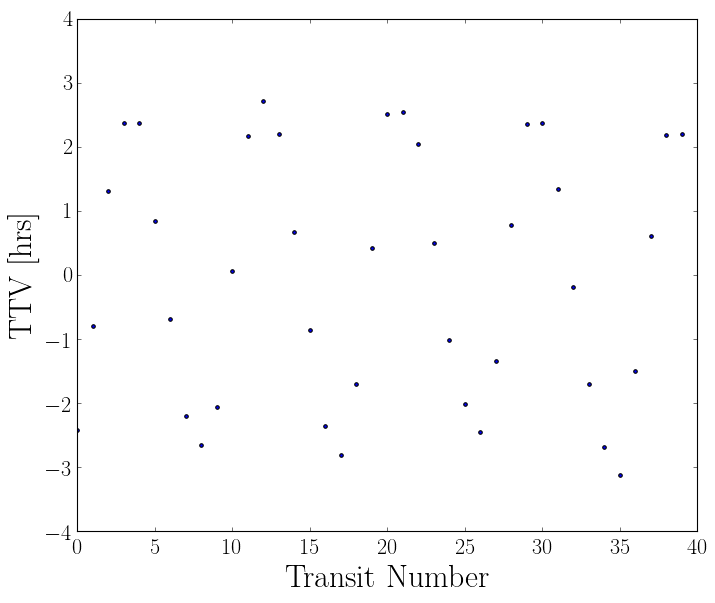

In [134]:
sim = rebound.Simulation()

sim.add(m=mstar)
for k in range(planets):
    sim.add(m=inclination_mass(np.pi/2, mass[k]), e=e[k], a=a[k], omega=w[k], M=M[k]) 
sim.move_to_com()

N = 40  # Integrate over 4 transits for planet b
transittimes = np.zeros(N)
p = sim.particles

j = 0 # Start the counter
while j < N:
    y_old = p[2].y - p[0].y  
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[j] = sim.t
        j += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit
        
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

fig = plt.figure(figsize=[10,8])
ax = plt.axes()
ax.set_xlim([0,N])
ax.set_xlabel("Transit Number", fontsize='x-large')
ax.set_ylabel("TTV [hrs]", fontsize='x-large')
#plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi), s = 0.5);
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c), s = 10);

We now want to measure the amplitude and period of the TTVs we've plotted. To find the amplitude, we can find the maximum of the TTVs. Since the sinusoid is not centered at zero, we subtract the sum of the maximum and minimum divided by 2 from the maximum to find the amplitude. To find the period, we can use autocorrelation and identify the transit number at which the periodicity correlation peaks.

The period of the TTVs is 9 transits
The amplitude of the TTVs is = 2.92386058705 hours


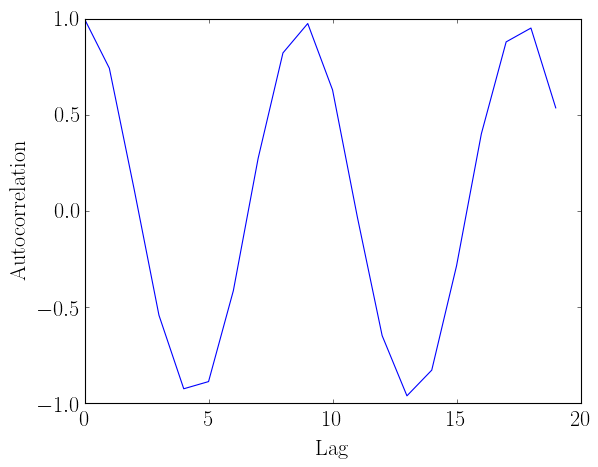

In [138]:
y = (transittimes-m*np.array(range(N))-c)

def acf(x, length=20):
    return np.array([1] +[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1,length)])

plt.plot(np.arange(len(acf(y))),acf(y))
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')

print("The period of the TTVs is {} transits".format(np.argmax(acf(y)[1:]) + 1))
print("The amplitude of the TTVs is = {} hours".format(max(y)-((max(y) + min(y)) / 2)))

We want to repeat the TTV calculation for double and half the mass of planet b, respectively. We will start with the $2 \times M_b$ case.

/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


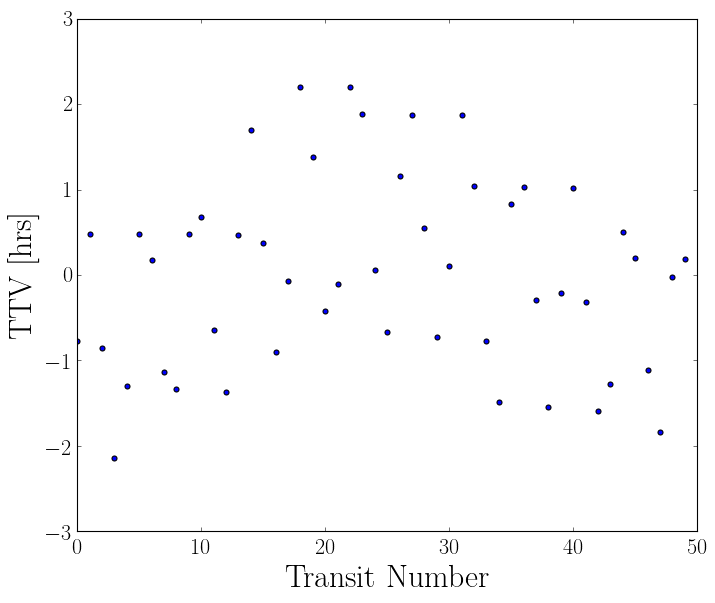

In [140]:
mass_double = np.array([0.021, 0.7142, 2*2.2756, 0.046]) * const.M_jup.value / const.M_sun.value

sim = rebound.Simulation()

sim.add(m=mstar)
for k in range(planets):
    sim.add(m=inclination_mass(np.pi/2, mass_double[k]), e=e[k], a=a[k], omega=w[k], M=M[k]) 
sim.move_to_com()

N = 50  # Integrate over 4 transits for planet c
transittimes_double = np.zeros(N)
p = sim.particles

j = 0 # Start the counter
while j < N:
    y_old = p[2].y - p[0].y  
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes_double[j] = sim.t
        j += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit
        
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes_double)[0]

fig = plt.figure(figsize=[10,8])
ax = plt.axes()
#ax.set_ylim([-1,1])
ax.set_xlim([0,N])
ax.set_xlabel("Transit Number", fontsize='x-large')
ax.set_ylabel("TTV [hrs]", fontsize='x-large')
plt.scatter(range(N), (transittimes_double-m*np.array(range(N))-c), s = 20);

The period of the TTVs is 4 transits
The amplitude of the TTVs is = 2.17137537853 hours


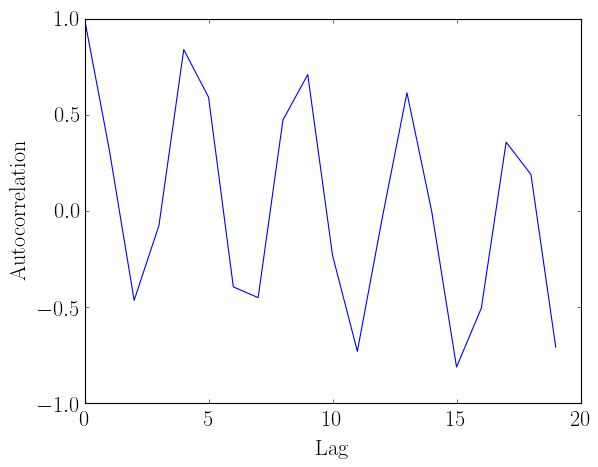

In [141]:
y = (transittimes_double-m*np.array(range(N))-c)

def acf(x, length=20):
    return np.array([1] +[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1,length)])

plt.plot(np.arange(len(acf(y))),acf(y))
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')

print("The period of the TTVs is {} transits".format(np.argmax(acf(y)[1:]) + 1))
print("The amplitude of the TTVs is = {} hours".format(max(y)-((max(y) + min(y)) / 2)))

We repeat the calculation with $\frac{1}{2} \times M_b$.

/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


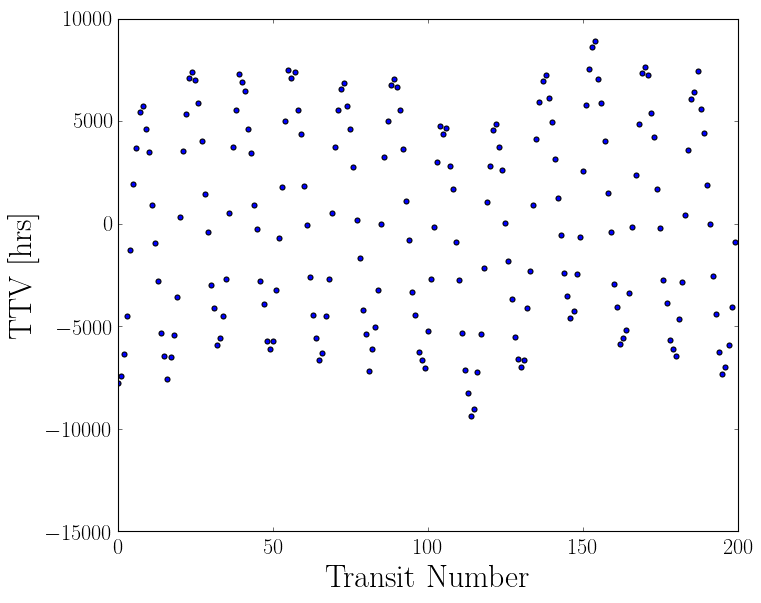

In [143]:
mass_half = np.array([0.021, 0.7142, 0.5*2.2756, 0.046]) * const.M_jup.value / const.M_sun.value

sim = rebound.Simulation()

sim.add(m=mstar)
for k in range(planets):
    sim.add(m=inclination_mass(np.pi/2, mass_half[k]), e=e[k], a=a[k], omega=w[k], M=M[k]) 
sim.move_to_com()

N = 200  # Integrate over 4 transits for planet b
transittimes_half = np.zeros(N)
p = sim.particles

j = 0 # Start the counter
while j < N:
    y_old = p[2].y - p[0].y  
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes_half[j] = sim.t
        j += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit
        
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes_half)[0]

fig = plt.figure(figsize=[10,8])
ax = plt.axes()
#ax.set_ylim([-1,1])
ax.set_xlim([0,N])
ax.set_xlabel("Transit Number", fontsize='x-large')
ax.set_ylabel("TTV [hrs]", fontsize='x-large')
plt.scatter(range(N), (transittimes_half-m*np.array(range(N))-c)*(24.*365./2./np.pi), s = 20);

The period of the TTVs is 16 transits
The amplitude of the TTVs is = 6.55057935279 hours


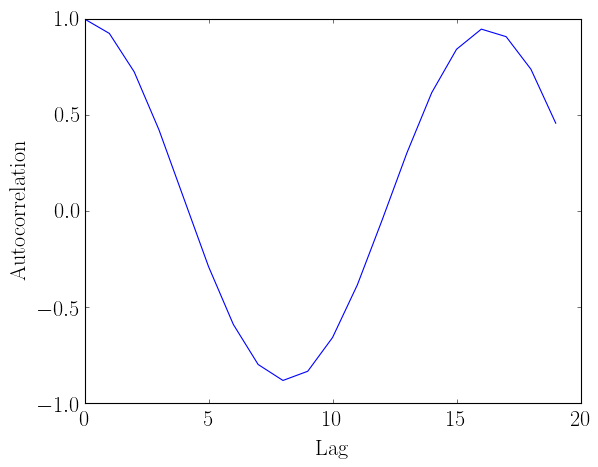

In [144]:
y = (transittimes_half-m*np.array(range(N))-c)

def acf(x, length=20):
    return np.array([1] +[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1,length)])

plt.plot(np.arange(len(acf(y))),acf(y))
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')

print("The period of the TTVs is {} transits".format(np.argmax(acf(y)[1:]) + 1))
print("The amplitude of the TTVs is = {} hours".format(max(y)-((max(y) + min(y)) / 2)))

We have found that increasing the mass of planet b decreases the TTV period and amplitude of planet c, while decreasing the mass of planet b increases the TTV period and amplitude of planet c. This means that a more massive planet b accelerates planet c more dramatically, decreasing the number of transits it takes to achieve the maximum perturbation to its orbit. Contrastingly, a less massive planet b accelerates planet c less, increasing the number of transits it takes to achieve the maximum orbital perturbation.